In [1]:
import sqlite3
conn = sqlite3.connect('employee.db', check_same_thread=False)
cursor = conn.cursor()

### Utilities

In [2]:
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """Create a ToolNode with a fallback to handle errors and surface them to the agent."""
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


### Defining Tools

In [3]:
from langchain_core.tools import tool
from langchain_core.pydantic_v1 import BaseModel, Field

@tool
def get_tables() -> str:
    """A tool to fetch the names of the available tables in the database"""
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    rows = cursor.fetchall()
    names = ', '.join([row[0] for row in rows])
    return names

@tool
def get_schema(table_names: list[str]):
    """Tool to get the Schema(DDL) of the given table name"""
    ddls = []
    for table in table_names:
        cursor.execute(f"SELECT * FROM (SELECT * FROM sqlite_master WHERE type='table') \
                    WHERE name='{table}'")
        ddls.append(cursor.fetchone()[-1])
    return ddls

class QuerySchema(BaseModel):
    query: str = Field(description="should be a SQL query")

@tool("execute_DML_query", args_schema=QuerySchema, return_direct=True)
def execute_DML_query(query: str) -> str:
    """Tool to execute DML SQL queries like INSERT, UPDATE, DELETE queries that updates the database records"""
    try:
        cursor.execute(query)
        conn.commit()
        return "Operation Success"
    except sqlite3.OperationalError as e:
        return f"Operation Failed: {e}"


@tool("execute_DQL_query", args_schema=QuerySchema, return_direct=True)
def execute_DQL_query(query: str):
    """Tool to execute DQL SQL queries like SELECT query that only reads data from the database"""
    cursor.execute(query)
    return cursor.fetchall()

@tool
def submit_query(query: str):
    """A tool to submit the SQL query."""
    return query

### Define Graph State

In [4]:
from typing import TypedDict, Annotated, Literal
from langgraph.graph import add_messages
from langgraph.graph.message import AnyMessage

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    tables: str

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

table_selection_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an SQL expert. Based on the Database Table names below determine which \
     table names are required for the user's question\n Database Tables: {tables}"),
     ("placeholder", '{messages}')
])

table_selection_llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0).bind_tools([get_schema])

table_selection_runnable = table_selection_prompt | table_selection_llm

In [6]:
examine_query_prompt_text = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.
If the query is a DQL query then call 'execute_DQL_query' tool and 
if the query is a DML query then call 'execute_DML_query' tool."""

examine_query_prompt = ChatPromptTemplate.from_messages([
    ('system', examine_query_prompt_text), ('placeholder', '{messages}')
])
examine_query_llm = ChatOpenAI(model='gpt-4o', temperature=0)\
    .bind_tools([execute_DQL_query, execute_DML_query], tool_choice='required')

examine_query_runnable = examine_query_prompt | examine_query_llm

In [13]:
generate_query_prompt_text = """
You are a SQL expert agent with a strong attention to detail. Given an input question and table schemas generate and submit a 
syntactically correct SQLite query. After generating the SQL query, use the 'submit_query' tool to submit the query.

Follow these guidelines:
1. For DQL (Data Query Language) Queries: 
- Output an SQL query that answers the user's question.
- If the user doesn't specify a specific number of examples to obtain, limit the query to at most 5 results.
- Order the results by a relevant column to return the most interesting examples from the database.
- Only select the columns relevant to the user's question; do not query all columns from a table.

2. For DML, DDL, or DCL Queries (Data Manipulation, Definition, or Control Language):
- Do not assume or create any fake data. Use only the information provided by the user.
- If the user's request lacks some necessary details, ask for the relevant information before generating the query.
"""
generate_query_prompt = ChatPromptTemplate.from_messages([
    ('system', generate_query_prompt_text),
    ('placeholder', '{messages}')
])
generate_query_llm = ChatOpenAI(model='gpt-4o', temperature=0)\
    .bind_tools([submit_query])

generate_query_runnable = generate_query_prompt | generate_query_llm

### Define Graph

In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, ToolMessage
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

###### Nodes ######
def table_selection_assistant(state: State):
    result = table_selection_runnable.invoke(state)
    return {'messages': result}

def SQL_query_assistant(state: State):
    result = generate_query_runnable.invoke(state)
    return {'messages': [result]}

def examine_query_assistant(state: State):
    # Adding Tool Message
    tool_call = state['messages'][-1].tool_calls[0]
    tool_message = ToolMessage(
        tool_call_id=tool_call['id'],
        name=tool_call['name'],
        content=submit_query.invoke(tool_call['args']))
    state['messages'] += [tool_message]

    result = examine_query_runnable.invoke(state)
    return {'messages': result}


###### Routes ######
def route_table_selection(state: State) -> Literal['get_schema', END]:
    route = tools_condition(state)
    if route == END:
        return END
    else:
        return 'get_schema'

def route_query_check(state: State) -> Literal[
    'execute_DQL_query', 'execute_DML_query']:
    
    route = tools_condition(state)
    if route == END:
        return END
    
    tool_calls = state['messages'][-1].tool_calls

    if tool_calls[0]['name'] == execute_DQL_query.name:
        return execute_DQL_query.name
    else:
        return execute_DML_query.name
    
def route_generate_query(state: State) -> Literal['examine_query_assistant', END]:
    route = tools_condition(state)
    if route == END:
        return END
    else:
        return 'examine_query_assistant'

####### Nodes #######
workflow.add_node('get_db_tables', lambda _ : {'tables': get_tables.invoke({})})
workflow.add_node('table_selection_assistant', table_selection_assistant)
workflow.add_node('get_schema', create_tool_node_with_fallback([get_schema]))
workflow.add_node('SQL_query_assistant', SQL_query_assistant)
workflow.add_node('examine_query_assistant', examine_query_assistant)

workflow.add_node('execute_DQL_query', 
                  create_tool_node_with_fallback([execute_DQL_query]))
workflow.add_node('execute_DML_query', ToolNode(tools=[execute_DML_query]))
# workflow.add_node('generate_answer', gen_ans)


####### Edges #######
workflow.add_edge(START, 'get_db_tables')
workflow.add_edge('get_db_tables', 'table_selection_assistant')
workflow.add_conditional_edges('table_selection_assistant', route_table_selection)
workflow.add_edge('get_schema', 'SQL_query_assistant')
workflow.add_conditional_edges('SQL_query_assistant', route_generate_query)
workflow.add_conditional_edges('examine_query_assistant', route_query_check)
workflow.add_edge('execute_DQL_query', 'SQL_query_assistant')
workflow.add_edge('execute_DML_query', 'SQL_query_assistant')

memory = MemorySaver()

graph = workflow.compile(
    checkpointer=memory,
    interrupt_before=['execute_DML_query']
)

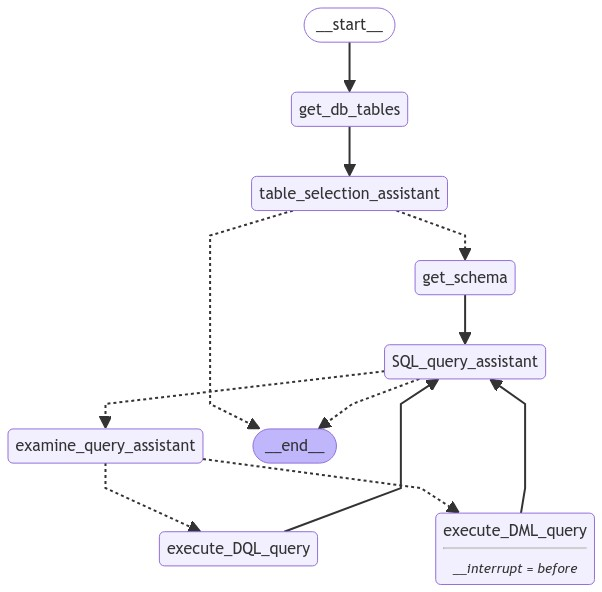

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
from typing import Optional
import json
def generate_verification_message(message: AIMessage) -> None:
    """Generate "verification message" from message with tool calls."""
    serialized_tool_calls = json.dumps(
        message.tool_calls,
        indent=2,
    )
    return AIMessage(
        content=(
            "I plan to invoke the following tools, do you approve?\n\n"
            "Type 'y' if you do, anything else to stop.\n\n"
            f"{serialized_tool_calls}"
        ),
        id=message.id,
    )

def stream_app_catch_tool_calls(inputs, thread) -> Optional[AIMessage]:
    """Stream graph, catching tool calls."""
    tool_call_message = None
    for event in graph.stream(inputs, thread, stream_mode="values"):
        message = event["messages"][-1]
        if isinstance(message, AIMessage) and message.tool_calls \
            and message.tool_calls[0]['name'] == execute_DML_query.name:
            tool_call_message = message
        else:
            message.pretty_print()

    return tool_call_message

In [16]:
import uuid
from langchain_core.messages import HumanMessage

query_1 = 'I want to add a new record to the employee table.'
query_2 = "I want to add a new record to the employee table. The employee's first name is Tapaswi, last name is Satyapanthi and he's a Software Engineer"
query_3 = 'Which sales agent made the most in sales in 2009?'
query_4 = 'Hey! How are you doing?'
query_5 = "How's the weather today?"
query_6 = 'What this database is about?'
query_7 = "Update the first record where the first name is Tapaswi and change his last name to 'Satyapanthi'"
query_8 = "Can you delete all the records with the name Tapaswi from the employees?"
query_9 = "Give me the list of all the employees."
query_10 = "What is the total sales?"
query_11 = "Show me the entire record of employee names Tapaswi"

thread = {"configurable": {"thread_id": str(uuid.uuid4())}}

tool_call_message = stream_app_catch_tool_calls(
    {"messages": [HumanMessage(query_3)]}, thread) #QUERY

snapshot = graph.get_state(thread)

while tool_call_message:
    verification_message = generate_verification_message(tool_call_message)
    verification_message.pretty_print()
    input_message = HumanMessage(input())
    if input_message.content == "exit":
        break
    input_message.pretty_print()
    snapshot = graph.get_state(thread)
    snapshot.values["messages"] += [verification_message, input_message]
    if input_message.content.strip().lower() in ['y', 'yes', 'ok']:
        tool_call_message.id = str(uuid.uuid4())
        snapshot.values["messages"] += [tool_call_message]
        graph.update_state(thread, snapshot.values, as_node="examine_query")
    else:
        graph.update_state(thread, snapshot.values, as_node="get_schema")
    
    tool_call_message = stream_app_catch_tool_calls(None, thread)

================================ Human Message =================================

Show me how many team members are there in Charlotte Hornets and Brooklyn Nets
================================ Human Message =================================

Show me how many team members are there in Charlotte Hornets and Brooklyn Nets
================================== Ai Message ==================================
Tool Calls:
  get_schema (call_duFtbOhcdwVl7Y6GEKaTzkUe)
 Call ID: call_duFtbOhcdwVl7Y6GEKaTzkUe
  Args:
    table_names: ['nba_roster']
================================= Tool Message =================================
Name: get_schema

["CREATE TABLE nba_roster (\n                    Team TEXT,\n                    NAME TEXT,\n                    Jersey TEXT,\n                    POS TEXT,\n                    AGE INT,\n                    HT TEXT,\n                    WT TEXT,\n                    COLLEGE TEXT,\n                    SALARY TEXT\n                )"]
=========================